# TEST different approach
The aim of this notbook is to try to use what we learn with the previous technique to propose a now class algorithm for corneal classification.

In [1]:
from src.image_OCT import *
from src.image_Quantification_3 import *
import math 
from sklearn import svm
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

dirname = os.getcwd()
print(dirname)
savefold=os.path.join(dirname, 'Data\Figure\\') # "C:/Users/csoub/OneDrive/Bureau/3A/Ensta/Super projet/Algo_Maelle/Data/Figure/"
extension=".png"
%matplotlib inline

c:\Users\csoub\OneDrive\Bureau\3A\Ensta\Super projet\Quantification_of_corneal_surgery_antecedent


## Exemple of treatments

Illustration of treatment on the data:
- flaten image croped
- Intensity profile with local max and exponential profile
- Intensity profile corrected by the exponential profile
- Bell curve localised on the profile with gaussian regression.

In [2]:
filepathname_haze1=os.path.join(dirname, 'Data','HAZE','haze 1.jpg')
filepathname_haze2=os.path.join(dirname, 'Data','HAZE','haze 3.jpg')
filepathname_healthy1=os.path.join(dirname, 'Data','Healthy','23923_BOULIS_OD.jpg')
filepathname_healthy2=os.path.join(dirname, 'Data','VILBERT_Maelle','test.jpg')
filepathname_fuchs1=os.path.join(dirname, 'Data','Fuchs_2','VANLUD_OD_6_Line.jpg')
# filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','FAIJEA_OS_1_Line.jpg')
filepathname_fuchs2=os.path.join(dirname, 'Data','Fuchs_2','SELNIC_OS_0_Line.jpg')

# filepathname=os.path.join(dirname, 'Data','Healthy','80608_REZAZK_OS.jpg')
test_ex=[filepathname_haze1,filepathname_haze2,filepathname_healthy1,filepathname_healthy2,filepathname_fuchs1,filepathname_fuchs2]
test_type=["haze1","haze2","healthy1","healthy2","fuchs1",'fuchs2']

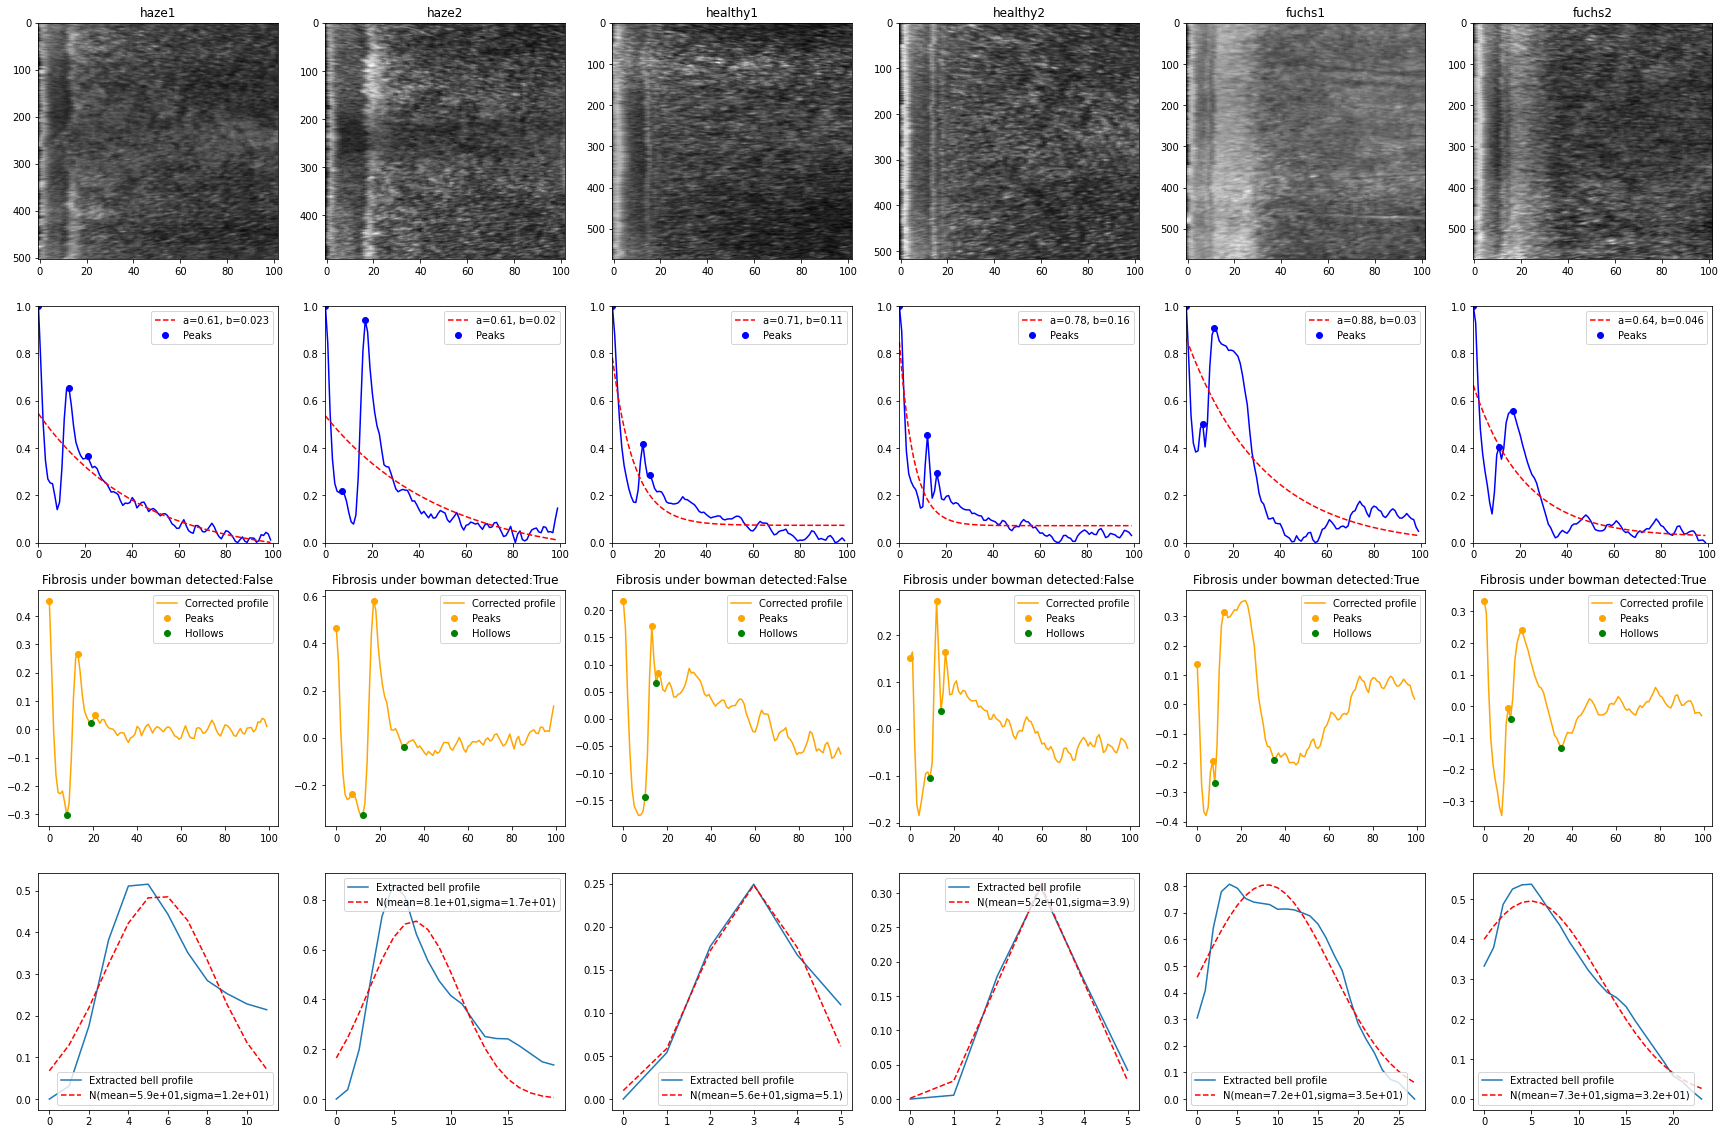

In [3]:
n=len(test_ex)
fig,ax=plt.subplots(4,n,figsize=(30,20))
move=False;eliminate=30;useExpCorr=False
for i,filepathname in enumerate(test_ex):
    name=test_type[i]
    im=image_OCT(filepathname)
    im.AutoTreatment()
    im_Q=image_Quantification_3(im,movingWin=False,eliminate=eliminate,useExpCorr=useExpCorr)
    ax[0][i].imshow((im_Q.image[im_Q.peaks[0]-im_Q.pre_window:im_Q.peaks[0]+im_Q.post_window][:]).T,aspect="auto",cmap="gray")
    ax[0][i].set_title(name)
    ax[1][i].plot(im_Q.iProfileCrop,'b')
    ax[1][i].plot(im_Q.iProfileExp,'r--',label="a={:.2}, b={:.2}".format(im_Q.Alpha,im_Q.Beta))
    ax[1][i].plot(im_Q.peaks-im_Q.xmin,im_Q.iProfileCrop[im_Q.peaks-im_Q.xmin],"bo",label="Peaks")
    ax[1][i].legend()
    ax[1][i].set_xlim([0,im_Q.pre_window+im_Q.post_window])
    ax[1][i].set_ylim([0,1])
    ax[2][i].plot(im_Q.iProfileExpCorrection,'orange',label='Corrected profile')
    ax[2][i].plot(im_Q.peaks-im_Q.xmin,im_Q.iProfileExpCorrection[im_Q.peaks-im_Q.xmin],color="orange",marker="o",linestyle='',label="Peaks")
    ax[2][i].plot(im_Q.hollows-im_Q.xmin,im_Q.iProfileExpCorrection[im_Q.hollows-im_Q.xmin],color="green",marker="o",linestyle='',label="Hollows")
    ax[2][i].set_title("Fibrosis under bowman detected:"+str(im_Q.underBowman))
    ax[2][i].legend()
    ax[3][i].plot(im_Q.iProfileBell-np.min(im_Q.iProfileBell),label="Extracted bell profile")
    ax[3][i].plot(im_Q.iProfileBellGauss,'r--',label="N(mean={:.2},sigma={:.2})".format(im_Q.Mean,im_Q.Sigma))
    ax[3][i].legend()
plt.show()

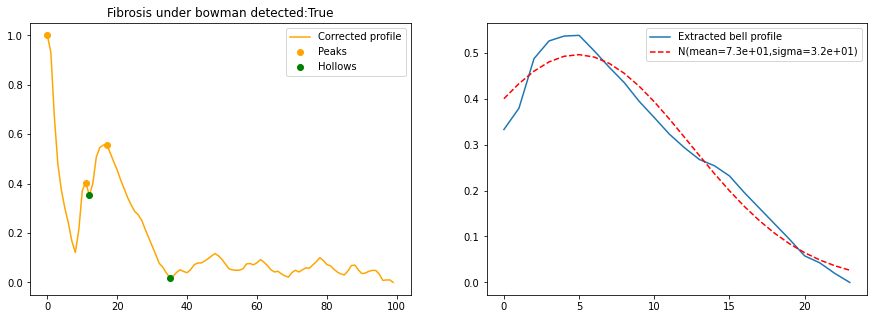

In [4]:
im=image_OCT(filepathname_fuchs2)
im.AutoTreatment()
im_Q=image_Quantification_3(im,movingWin=False,eliminate=eliminate,useExpCorr=useExpCorr)
im_Q.Plot_ProfileQuantif()

## Computing data sets:

In [5]:
# Compute or import dataset
move=True
useExpCorr=False
# folder="exp_correction/"
# append="_mov_win-exp_corr_"
append="_mov_win_"
folder=""

try:
	data_healthy = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_healthy"+append+".pkl")
except:
	repertory_healthy=os.path.join(dirname, 'Data','Healthy')
	healthy_value=1 #healthy
	data_healthy=create_new_dataset(repertory_healthy,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy.to_pickle("./Dataset/data_set_Q3_healthy"+append+".pkl")
 
try:
	data_healthy_2 = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_healthy_2"+append+".pkl")
except:
	repertory_healthy_2=os.path.join(dirname, 'Data','Healthy_2')
	healthy_value=1 #healthy
	data_healthy_2=create_new_dataset(repertory_healthy_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_healthy_2.to_pickle("./Dataset/data_set_Q3_healthy_2"+append+".pkl")
try:
	data_haze = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_haze"+append+".pkl")
except:
	repertory_haze=os.path.join(dirname, 'Data','HAZE')
	healthy_value=0 #patho
	data_haze=create_new_dataset(repertory_haze,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze.to_pickle("./Dataset/data_set_Q3_haze"+append+".pkl")

try:
	data_haze_2 = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_haze_2"+append+".pkl")
except:
	repertory_haze_2=os.path.join(dirname, 'Data','HAZE_2')
	healthy_value=0 #patho
	data_haze_2=create_new_dataset(repertory_haze_2,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_haze_2.to_pickle("./Dataset/data_set_Q3_haze_2"+append+".pkl")

try:
	data_fuchs = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_fuchs"+append+".pkl")
except:
	repertory_fuchs=os.path.join(dirname, 'Data','Fuchs_2')
	healthy_value=2 #fushs
	data_fuchs=create_new_dataset(repertory_fuchs,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs.to_pickle("./Dataset/data_set_Q3_fuchs"+append+".pkl")

try:
	data_fuchs_rep = pd.read_pickle("./Dataset/"+folder+"data_set_Q3_fuchs_rep"+append+".pkl") 
except:
	repertory_fuchs_rep=os.path.join(dirname, 'Data','repetabilite_FuchsDMEK')
	healthy_value=2 #fushs
	data_fuchs_rep=create_new_dataset(repertory_fuchs_rep,healthy_value,movingWin=move,eliminate=eliminate,useExpCorr=useExpCorr)
	data_fuchs_rep.to_pickle("./Dataset/data_set_Q3_fuchs_rep"+append+".pkl")

print("Succesfully imported")

Succesfully imported


In [6]:
data_healthy

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,Alpha,Beta,IntensityPeak,Healthy,Origin
0,29.377499,6.707442,0.011095,56.586335,0.071527,0.033430,0.800103,0.157229,0.501436,1,23923_BOULIS_OD
1,23.346463,5.161864,0.017582,62.723819,0.097157,0.033998,-0.227268,0.241946,0.549070,1,79296_BESNIC_OD
2,24.577840,5.729504,0.021760,58.187680,0.108918,0.029463,0.850396,0.234769,0.707970,1,80552_CORANT_OD
3,26.886356,6.350019,0.032628,52.346252,0.117584,0.039675,0.428578,0.291449,0.662627,1,80552_CORANT_OS
4,27.007220,6.168424,0.014145,53.626757,0.085840,0.029083,0.771240,0.126761,0.647156,1,80553_DUMFAU_OD
5,24.382203,5.092811,0.018810,50.516571,0.075393,0.039008,0.810627,0.282446,0.509573,1,80553_DUMFAU_OS
6,33.724166,10.010979,0.006804,58.881420,0.102036,0.031611,0.905923,0.318419,0.512751,1,80608_REZAZK_OD
7,22.873647,6.496969,0.014594,58.387897,0.107305,0.027194,0.758560,0.418982,0.473067,1,80608_REZAZK_OS
8,23.907040,4.619372,0.038992,55.956823,0.076108,0.055155,0.817529,0.217229,0.733642,1,81225_GOLDIM_OD
9,24.048753,4.382761,0.031497,55.326236,0.047062,0.061797,0.823523,0.171189,0.700803,1,81225_GOLDIM_OS


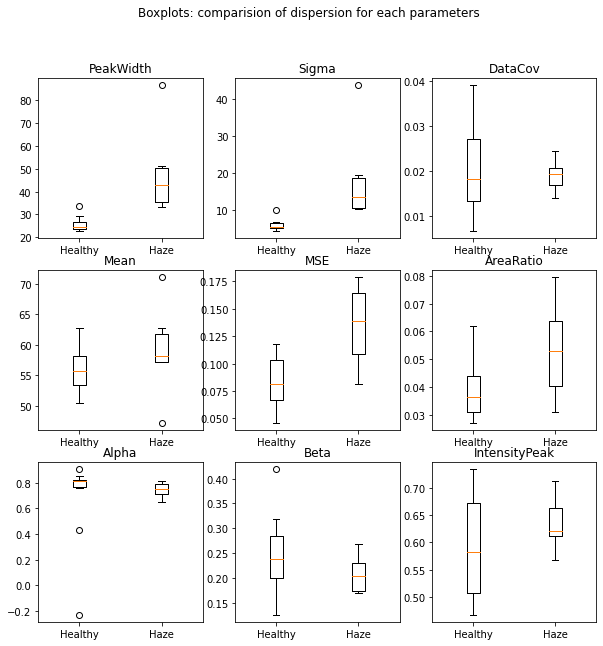

In [7]:
variable=data_healthy.columns[:-2]
k=len(variable)

column=int(np.sqrt(k))
line=int(k/column)
fig,ax=plt.subplots(line,column,figsize=(10,10))
fig.suptitle('Boxplots: comparision of dispersion for each parameters', fontsize=12)
for i in range(line):
	for j in range(column):
		p=i*line+j
		if p<k:
			var_name=variable[p]
			ax[i][j].boxplot([data_healthy[var_name],data_haze[var_name]])
			ax[i][j].set_xticklabels(["Healthy","Haze"])
			ax[i][j].set_title(var_name)
		

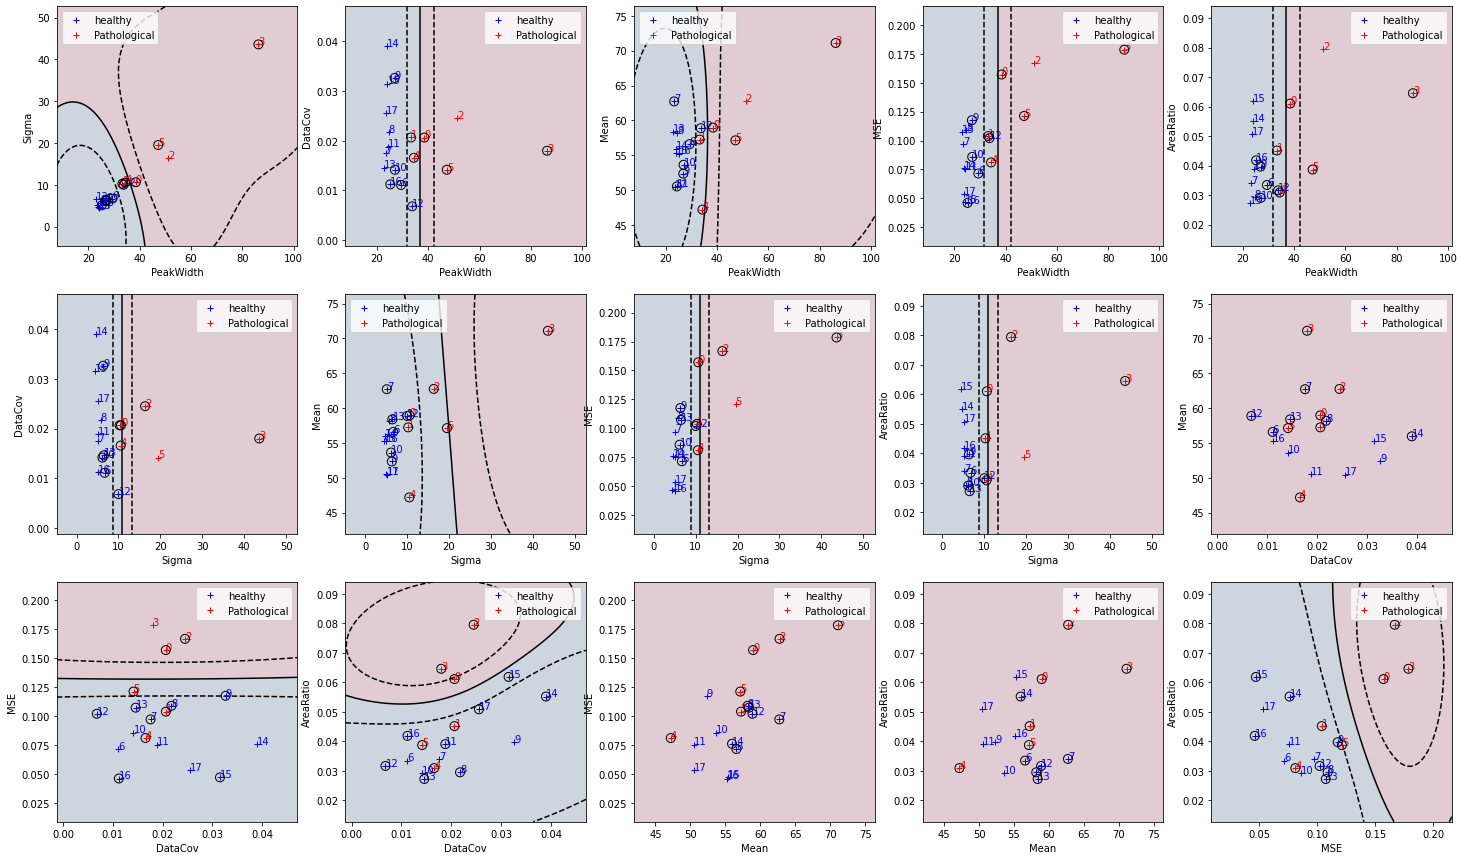

In [8]:
#Plot two by two
import warnings
warnings.filterwarnings("ignore")
data_learning=pd.concat([data_haze,data_healthy],ignore_index=True)
data=data_learning
data_copy=data.drop(["Healthy","Origin","Alpha","Beta","IntensityPeak"],axis=1)
data_copy=(data_copy-np.mean(data_copy,0))/np.std(data_copy,0)
data_set_mean=np.mean(data_copy,0)
data_set_std=np.std(data_copy,0)
cor=data_copy.corr()
# sns.heatmap(cor, square = True, cmap="coolwarm",linewidths=.5,annot=True )

variable=data_copy.columns
k=len(variable)
comb=math.comb(k,2)
	
nline=3
ncol=comb//nline+int(comb/nline-comb//nline+0.5)
plt.figure(figsize=(ncol*5,nline*5))
l=0
for i in range(k-1):
    for j in range(i+1,k):
        l+=1
        plt.subplot(nline,ncol,l)
        x_class1=data[variable[i]][data["Healthy"]==1]
        y_class1=data[variable[j]][data["Healthy"]==1]
        x_class0=data[variable[i]][data["Healthy"]==0]
        y_class0=data[variable[j]][data["Healthy"]==0]
        plt.plot(x_class1.T,y_class1.T,"b+",label="healthy")
        plt.plot(x_class0.T,y_class0.T,"r+",label="Pathological")
        for m in range(len(data)):
            if data["Healthy"][m]==1:
                plt.text(data[variable[i]][m],data[variable[j]][m],str(m),color="blue")
            else:
                plt.text(data[variable[i]][m],data[variable[j]][m],str(m),color="red")
        X=data[variable[i]]
        Y=data[variable[j]]
        Z=np.array([X.to_numpy().T,Y.to_numpy().T]).T
        C=np.array([data["Healthy"].to_numpy()]).T
        clf = svm.SVC()
        clf.fit(Z, C)
        x_min = Z[:, 0].min()-1*np.std(Z[:, 0])
        x_max = Z[:, 0].max()+1*np.std(Z[:, 0])
        y_min = Z[:, 1].min()-1*np.std(Z[:, 1])
        y_max = Z[:, 1].max()+1*np.std(Z[:, 1])
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
        Z = Z.reshape(XX.shape)
        plt.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],s=80,facecolors="none",zorder=10,edgecolors="k")
        plt.pcolormesh(XX, YY, Z > 0, cmap="RdBu",alpha=0.2) #plt.cm.Paired
        plt.contour(XX,YY,Z,colors=["k", "k", "k"],linestyles=["--", "-", "--"],levels=[-0.5, 0, 0.5],linewidth=0.1)
        plt.xlabel(variable[i])
        plt.ylabel(variable[j])
        plt.legend()
        

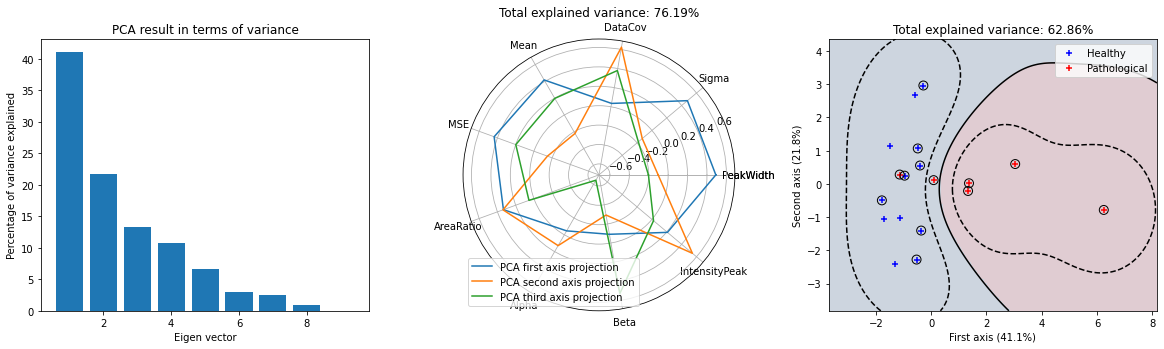

In [9]:
# PCA
data_copy=data.drop(["Healthy","Origin"],axis=1)
data_set_mean=np.mean(data_copy,0)
data_set_std=np.std(data_copy,0)
data_copy=(data_copy-data_set_mean)/data_set_std
N=len(data_copy)
K=len(data_copy.columns)
pca = PCA()
pca.fit(data_copy)


plt.figure(figsize=(20,5))
plt.subplot(131)
plt.bar(np.arange(1,K+1,1),pca.explained_variance_ratio_*100)
plt.xlabel('Eigen vector')
plt.ylabel('Percentage of variance explained')
plt.title("PCA result in terms of variance")
plt.subplot(132,polar=True)
categories = data_copy.columns
categories = [*categories, categories[0]]
axis1= pca.components_[0]
axis1 = [*axis1, axis1[0]]
axis2= pca.components_[1]
axis2 = [*axis2, axis2[0]]
axis3= pca.components_[2]
axis3 = [*axis3, axis3[0]]
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(axis1))
plt.plot(label_loc, axis1, label='PCA first axis projection')
plt.plot(label_loc, axis2, label='PCA second axis projection')
plt.plot(label_loc, axis3, label='PCA third axis projection')
plt.title("Total explained variance: {:.2f}%".format(np.sum(pca.explained_variance_ratio_[0:3])*100))
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()

X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.array([X.to_numpy().T,Y.to_numpy().T]).T
C=np.array([data["Healthy"].to_numpy()]).T
clf = svm.SVC()
clf.fit(Z, C)
x_min = Z[:, 0].min()-1*np.std(Z[:, 0])
x_max = Z[:, 0].max()+1*np.std(Z[:, 0])
y_min = Z[:, 1].min()-1*np.std(Z[:, 1])
y_max = Z[:, 1].max()+1*np.std(Z[:, 1])

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

plt.subplot(133)
plt.scatter(X[data["Healthy"]==1],Y[data["Healthy"]==1],c="b",marker="+",label="Healthy",zorder=10)
plt.scatter(X[data["Healthy"]==0],Y[data["Healthy"]==0],c="r",marker="+",label="Pathological",zorder=10)

plt.scatter(clf.support_vectors_[:, 0],clf.support_vectors_[:, 1],s=80,facecolors="none",zorder=10,edgecolors="k")
plt.pcolormesh(XX, YY, Z > 0, cmap="RdBu",alpha=0.2) #plt.cm.Paired
plt.contour(XX,YY,Z,colors=["k", "k", "k"],linestyles=["--", "-", "--"],levels=[-0.5, 0, 0.5],linewidth=1)
plt.xlabel("First axis ({:.1f}%)".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("Second axis ({:.1f}%)".format(pca.explained_variance_ratio_[1]*100))
plt.title("Total explained variance: {:.2f}%".format(np.sum(pca.explained_variance_ratio_[0:2])*100))
plt.legend()

# pca = PCA(n_components=2)
# data_proj=pca.fit(data_copy,data["Healthy"])

In [10]:
data_haze_2

,PeakWidth,Sigma,DataCov,Mean,MSE,AreaRatio,Alpha,Beta,IntensityPeak,Healthy,Origin
0,19.242902,4.197423,0.010415,54.230942,0.044398,0.024289,-10.636429,0.242152,0.443530,0,AUBOLI_OD_Line_normal
1,41.857504,11.404915,0.013796,53.862961,0.095594,0.045749,0.802080,0.140352,0.605460,0,AUBOLI_OD_Line_PKR_M1
2,40.240173,9.943146,0.007933,61.283483,0.065550,0.052824,0.813887,0.190571,0.431844,0,AUBOLI_OD_Line_PKR_M3
3,30.137346,7.173162,0.011347,55.654784,0.070656,0.036251,-14.765116,0.187385,0.468861,0,AUBOLI_OD_Line_PKR_M6
4,29.993050,7.127443,0.007859,58.418088,0.058606,0.039615,0.839368,0.204318,0.395304,0,AUBOLI_OD_Line_PKR_M9
5,19.184689,4.343267,0.007319,54.983745,0.041154,0.030576,0.280825,0.286525,0.329916,0,AUBOLI_OS_Line_normal
6,21.493153,5.249747,0.027762,58.112593,0.086243,0.027193,1.206366,0.206100,0.674395,0,BOUEMI_OD_Line_normal
7,31.827635,10.413427,0.008833,60.235166,0.050552,0.016311,0.858487,0.088235,0.516020,0,BOUEMI_OD_Line_PKR_M0
8,30.792863,8.886203,0.010201,62.317024,0.083093,0.033289,-1.957560,0.189256,0.482242,0,BOUEMI_OD_Line_PKR_M4
9,43.385961,14.089294,0.011685,72.033228,0.112852,0.054236,0.916569,0.132007,0.576860,0,BOUEMI_OD_Line_PKR_M7


In [11]:
if 'Month' not in data_haze_2.columns:
	origin=data_haze_2["Origin"]
	n=len(origin)
	month=[]
	id_patient=[]
	eye=[]
	for i in range(n):
		text=origin[i]
		text=text.split('_')
		if text[-2]=="normal":
			month.append(0)
		else:
			month.append(int(text[-2][1:]))
		id_patient.append(text[0])
		eye.append(text[1])

	data_haze_2["Month"]=month
	data_haze_2["Id_patient"]=id_patient
	data_haze_2["Eye"]=eye
	data_haze_2.to_pickle("./Dataset/data_set_Q3_haze_2.pkl")

ValueError: invalid literal for int() with base 10: 'ine'

In [ ]:
data_copy=data_healthy.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-data_set_mean)/(data_set_std)
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.sum(data_copy*pca.components_[2],axis=1)
new = data_healthy.filter(["Healthy","Origin"], axis=1)
new['X']=X;new['Y']=Y;new['Z']=Z
data_healthy_new=new

data_copy=data_haze.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-data_set_mean)/(data_set_std)
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.sum(data_copy*pca.components_[2],axis=1)
new = data_haze.filter(["Healthy","Origin"], axis=1)
new['X']=X;new['Y']=Y;new['Z']=Z
data_haze_new=new

data_copy=data_healthy_2.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-data_set_mean)/(data_set_std)
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.sum(data_copy*pca.components_[2],axis=1)
new = data_healthy_2.filter(["Healthy","Origin"], axis=1)
new['X']=X;new['Y']=Y;new['Z']=Z
data_healthy2_new=new

data_copy=data_haze_2.drop(["Healthy","Origin","Month","Eye","Id_patient"],axis=1)
data_copy=(data_copy-data_set_mean)/(data_set_std)
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.sum(data_copy*pca.components_[2],axis=1)
new = data_haze_2.filter(["Healthy","Origin","Eye","Id_patient","Month"], axis=1)
new['X']=X;new['Y']=Y;new['Z']=Z
data_haze2_new=new

data_copy=data_fuchs.drop(["Healthy","Origin"],axis=1)
data_copy=(data_copy-data_set_mean)/(data_set_std)
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.sum(data_copy*pca.components_[2],axis=1)
new = data_fuchs.filter(["Healthy","Origin"], axis=1)
new['X']=X;new['Y']=Y;new['Z']=Z
data_fuchs_new=new

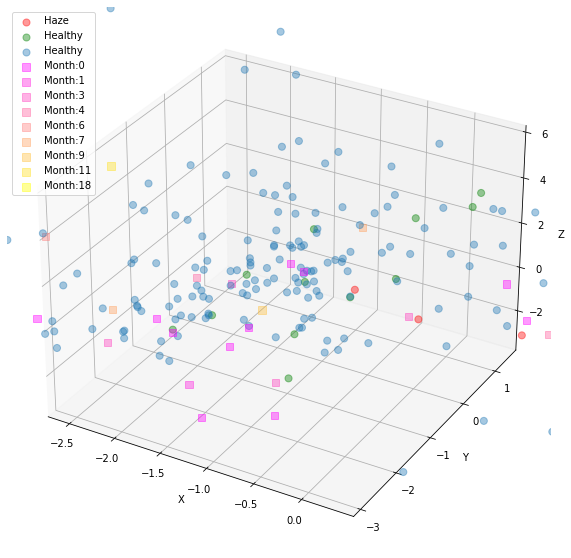

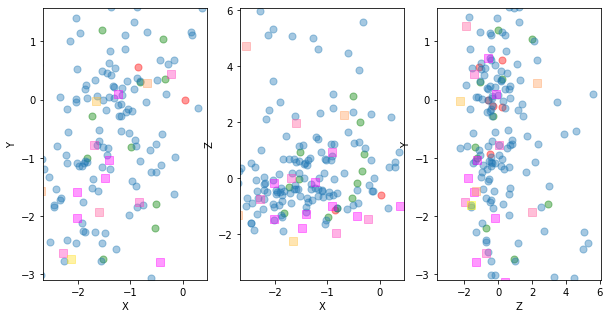

In [ ]:
warnings.filterwarnings("ignore")
from matplotlib import cm

df=pd.concat([data_haze2_new,data_healthy2_new],ignore_index=True)
colors = cm.spring(np.linspace(0, 1, len(np.unique(data_haze2_new["Month"]))))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

alpha=0.4
ax.scatter(data_haze_new["X"],data_haze_new["Y"],data_haze_new["Z"],marker='o',c='r',s=50,label="Haze",alpha=alpha)
ax.scatter(data_healthy_new["X"],data_healthy_new["Y"],data_healthy_new["Z"],marker='o',c='g',s=50,label="Healthy",alpha=alpha)
ax.scatter(data_healthy2_new["X"],data_healthy2_new["Y"],data_healthy2_new["Z"],marker='o',s=50,label="Healthy",alpha=alpha)
for i,m in enumerate(np.unique(data_haze2_new["Month"])):
	filter=data_haze2_new["Month"]==m
	ax.scatter(data_haze2_new["X"][filter],data_haze2_new["Y"][filter],data_haze2_new["Z"][filter],marker='s',color=colors[i],s=50,label="Month:"+str(m),alpha=alpha)

ax.legend()
ax.set_xlabel("X");ax.set_ylabel("Y");ax.set_zlabel("Z")
ax.set_xlim([np.mean(df["X"])-np.std(df["X"]),np.mean(df["X"])+np.std(df["X"])])
ax.set_ylim([np.mean(df["Y"])-np.std(df["Y"]),np.mean(df["Y"])+np.std(df["Y"])])
ax.set_zlim([np.mean(df["Z"])-np.std(df["Z"]),np.mean(df["Z"])+np.std(df["Z"])])

fig,ax=plt.subplots(1,3,figsize=(10,5))
ax[0].scatter(data_haze_new["X"],data_haze_new["Y"],marker='o',c='r',s=50,label="Haze",alpha=alpha)
ax[0].scatter(data_healthy_new["X"],data_healthy_new["Y"],marker='o',c='g',s=50,label="Healthy",alpha=alpha)
ax[0].scatter(data_healthy2_new["X"],data_healthy2_new["Y"],marker='o',s=50,label="Healthy",alpha=alpha)
for i,m in enumerate(np.unique(data_haze2_new["Month"])):
	filter=data_haze2_new["Month"]==m
	ax[0].scatter(data_haze2_new["X"][filter],data_haze2_new["Y"][filter],marker='s',color=colors[i],s=50,label="Month:"+str(m),alpha=alpha)
	ax[0].set_xlabel("X")
	ax[0].set_ylabel("Y")
	ax[0].set_xlim([np.mean(df["X"])-np.std(df["X"]),np.mean(df["X"])+np.std(df["X"])])
	ax[0].set_ylim([np.mean(df["Y"])-np.std(df["Y"]),np.mean(df["Y"])+np.std(df["Y"])])

ax[1].scatter(data_haze_new["X"],data_haze_new["Z"],marker='o',c='r',s=50,label="Haze",alpha=alpha)
ax[1].scatter(data_healthy_new["X"],data_healthy_new["Z"],marker='o',c='g',s=50,label="Healthy",alpha=alpha)
ax[1].scatter(data_healthy2_new["X"],data_healthy2_new["Z"],marker='o',s=50,label="Healthy",alpha=alpha)
for i,m in enumerate(np.unique(data_haze2_new["Month"])):
	filter=data_haze2_new["Month"]==m
	ax[1].scatter(data_haze2_new["X"][filter],data_haze2_new["Z"][filter],marker='s',color=colors[i],s=50,label="Month:"+str(m),alpha=alpha)
	ax[1].set_xlabel("X")
	ax[1].set_ylabel("Z")
	ax[1].set_xlim([np.mean(df["X"])-np.std(df["X"]),np.mean(df["X"])+np.std(df["X"])])
	ax[1].set_ylim([np.mean(df["Z"])-np.std(df["Z"]),np.mean(df["Z"])+np.std(df["Z"])])

ax[2].scatter(data_haze_new["Z"],data_haze_new["Y"],marker='o',c='r',s=50,label="Haze",alpha=alpha)
ax[2].scatter(data_healthy_new["Z"],data_healthy_new["Y"],marker='o',c='g',s=50,label="Healthy",alpha=alpha)
ax[2].scatter(data_healthy2_new["Z"],data_healthy2_new["Y"],marker='o',s=50,label="Healthy",alpha=alpha)
for i,m in enumerate(np.unique(data_haze2_new["Month"])):
	filter=data_haze2_new["Month"]==m
	ax[2].scatter(data_haze2_new["Z"][filter],data_haze2_new["Y"][filter],marker='s',color=colors[i],s=50,label="Month:"+str(m),alpha=alpha)
	ax[2].set_xlabel("Z")
	ax[2].set_ylabel("Y")
	ax[2].set_xlim([np.mean(df["Z"])-np.std(df["Z"]),np.mean(df["Z"])+np.std(df["Z"])])
	ax[2].set_ylim([np.mean(df["Y"])-np.std(df["Y"]),np.mean(df["Y"])+np.std(df["Y"])])


## Repetability

In [ ]:
## Repetability
if 'Id_patient_eye' not in data_fuchs_rep.columns:
	origin=data_fuchs_rep["Origin"]
	n=len(origin)
	repetition=[]
	id_patient=[]
	id_patient_eye=[]
	eye=[]
	for i in range(n):
		text=origin[i]
		text=text.split('_')
		repetition.append(int(text[-1]))
		id_patient.append(text[0])
		id_patient_eye.append(text[0]+text[2])
		eye.append(text[2])

	data_fuchs_rep["Repetition"]=repetition
	data_fuchs_rep["Id_patient"]=id_patient
	data_fuchs_rep["Id_patient_eye"]=id_patient_eye
	data_fuchs_rep["Eye"]=eye
	data_fuchs_rep.to_pickle("./Dataset/data_set_Q3_fuchs_rep.pkl")

data_copy=data_fuchs_rep.drop(["Healthy","Origin","Eye","Repetition","Id_patient","Id_patient_eye"],axis=1)
data_copy=(data_copy-data_set_mean)/(data_set_std)
X=np.sum(data_copy*pca.components_[0],axis=1)
Y=np.sum(data_copy*pca.components_[1],axis=1)
Z=np.sum(data_copy*pca.components_[2],axis=1)
new = data_fuchs_rep.filter(["Healthy","Origin","Eye","Id_patient","Repetition","Id_patient_eye"], axis=1)
new['X']=X;new['Y']=Y;new['Z']=Z
data_fuchs_rep_new=new

Text(0.5, 1.0, 'Repetability Q3 move:True expcorr:False')

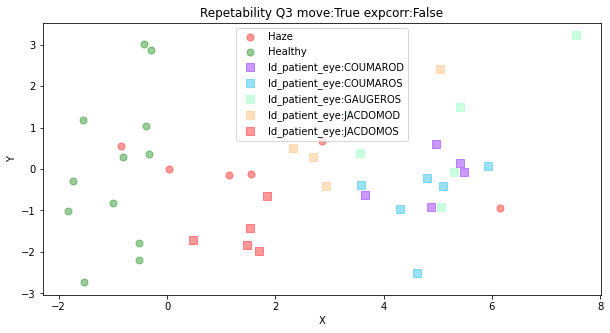

In [ ]:
plt.figure(figsize=(10,5))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(data_fuchs_rep_new["Id_patient_eye"]))))
plt.scatter(data_haze_new["X"],data_haze_new["Y"],marker='o',c='r',s=50,label="Haze",alpha=alpha)
plt.scatter(data_healthy_new["X"],data_healthy_new["Y"],marker='o',c='g',s=50,label="Healthy",alpha=alpha)
# ax[0].scatter(data_healthy2_new["X"],data_healthy2_new["Y"],marker='o',s=50,label="Healthy",alpha=alpha)
for i,m in enumerate(np.unique(data_fuchs_rep_new["Id_patient_eye"])):
	filter=data_fuchs_rep_new["Id_patient_eye"]==m
	plt.scatter(data_fuchs_rep_new["X"][filter],data_fuchs_rep_new["Y"][filter],marker='s',color=colors[i],s=50,label="Id_patient_eye:"+str(m),alpha=alpha)
	plt.xlabel("X")
	plt.ylabel("Y")
	# ax[0].set_xlim([np.mean(df["X"])-np.std(df["X"]),np.mean(df["X"])+np.std(df["X"])])
	# ax[0].set_ylim([np.mean(df["Y"])-np.std(df["Y"]),np.mean(df["Y"])+np.std(df["Y"])])
plt.legend()
plt.title("Repetability Q3 move:"+str(move)+" expcorr:"+str(useExpCorr))

In [ ]:
print("Q3:")
for i,m in enumerate(np.unique(data_fuchs_rep_new["Id_patient_eye"])):
	filter=data_fuchs_rep_new["Id_patient_eye"]==m
	X=data_fuchs_rep_new["X"][filter]
	Y=data_fuchs_rep_new["Y"][filter]
	print(m+":\n	Xmean={:.2f}, Ymean={:.2f}\n	Xsigma={:.2f}, Ysigma={:.2f}".format(np.mean(X),np.mean(Y),np.std(X),np.std(Y)))
	# ax[0].set_xlim([np.mean(df["X"])-np.std(df["X"]),np.mean(df["X"])+np.std(df["X"])])
	# ax[0].set_ylim([np.mean(df["Y"])-np.std(df["Y"]),np.mean(df["Y"])+np.std(df["Y"])])

Q3:
COUMAROD:
	Xmean=4.88, Ymean=-0.17
	Xsigma=0.66, Ysigma=0.54
COUMAROS:
	Xmean=4.72, Ymean=-0.74
	Xsigma=0.72, Ysigma=0.85
GAUGEROS:
	Xmean=5.03, Ymean=0.92
	Xsigma=1.40, Ysigma=1.32
JACDOMOD:
	Xmean=3.25, Ymean=0.70
	Xsigma=1.05, Ysigma=1.04
JACDOMOS:
	Xmean=1.41, Ymean=-1.52
	Xsigma=0.48, Ysigma=0.47


Text(0.5, 1.0, 'Repetability Q3 move:True expcorr:False')

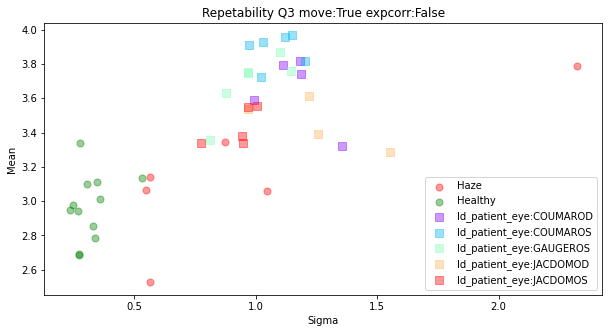

In [ ]:
plt.figure(figsize=(10,5))
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(data_fuchs_rep["Id_patient_eye"]))))
plt.scatter(data_haze["Sigma"],data_haze["Mean"],marker='o',c='r',s=50,label="Haze",alpha=alpha)
plt.scatter(data_healthy["Sigma"],data_healthy["Mean"],marker='o',c='g',s=50,label="Healthy",alpha=alpha)
# ax[0].scatter(data_healthy2_new["X"],data_healthy2_new["Y"],marker='o',s=50,label="Healthy",alpha=alpha)
for i,m in enumerate(np.unique(data_fuchs_rep["Id_patient_eye"])):
	filter=data_fuchs_rep["Id_patient_eye"]==m
	plt.scatter(data_fuchs_rep["Sigma"][filter],data_fuchs_rep["Mean"][filter],marker='s',color=colors[i],s=50,label="Id_patient_eye:"+str(m),alpha=alpha)
	plt.xlabel("Sigma")
	plt.ylabel("Mean")
plt.legend()
plt.title("Repetability Q3 move:"+str(move)+" expcorr:"+str(useExpCorr))

In [ ]:
print("Q3:")
for i,m in enumerate(np.unique(data_fuchs_rep["Id_patient_eye"])):
	filter=data_fuchs_rep["Id_patient_eye"]==m
	X=data_fuchs_rep["Sigma"][filter]
	Y=data_fuchs_rep["Mean"][filter]
	print(m+":\n	S-mean={:.2f}, M-mean={:.2f}\n	S-std={:.2f}, M-std={:.2f}".format(np.mean(X),np.mean(Y),np.std(X),np.std(Y)))

Q3:
COUMAROD:
	S-mean=1.17, M-mean=3.65
	S-std=0.12, M-std=0.18
COUMAROS:
	S-mean=1.08, M-mean=3.88
	S-std=0.08, M-std=0.09
GAUGEROS:
	S-mean=0.98, M-mean=3.69
	S-std=0.12, M-std=0.16
JACDOMOD:
	S-mean=1.25, M-mean=3.46
	S-std=0.21, M-std=0.13
JACDOMOS:
	S-mean=0.93, M-mean=3.43
	S-std=0.08, M-std=0.10


In [ ]:
data_fuchs_rep_new

,Healthy,Origin,Eye,Id_patient,Repetition,Id_patient_eye,X,Y,Z
0,2,COUMAR_FuchsDMEK_OD_Line_0,OD,COUMAR,0,COUMAROD,5.491672,-0.063282,-0.550961
1,2,COUMAR_FuchsDMEK_OD_Line_1,OD,COUMAR,1,COUMAROD,4.883675,-0.908373,-0.060574
2,2,COUMAR_FuchsDMEK_OD_Line_2,OD,COUMAR,2,COUMAROD,5.414480,0.156236,-0.437999
3,2,COUMAR_FuchsDMEK_OD_Line_3,OD,COUMAR,3,COUMAROD,4.966288,0.602515,-0.825761
4,2,COUMAR_FuchsDMEK_OD_Line_4,OD,COUMAR,4,COUMAROD,3.664200,-0.614948,-0.342342
5,2,COUMAR_FuchsDMEK_OS_Line_0,OS,COUMAR,0,COUMAROS,4.805184,-0.225604,-0.919018
6,2,COUMAR_FuchsDMEK_OS_Line_1,OS,COUMAR,1,COUMAROS,5.932174,0.063809,2.784015
7,2,COUMAR_FuchsDMEK_OS_Line_2,OS,COUMAR,2,COUMAROS,4.610477,-2.499523,9.998683
8,2,COUMAR_FuchsDMEK_OS_Line_3,OS,COUMAR,3,COUMAROS,4.307284,-0.968328,-0.664326
9,2,COUMAR_FuchsDMEK_OS_Line_4,OS,COUMAR,4,COUMAROS,3.573221,-0.385764,-1.090975


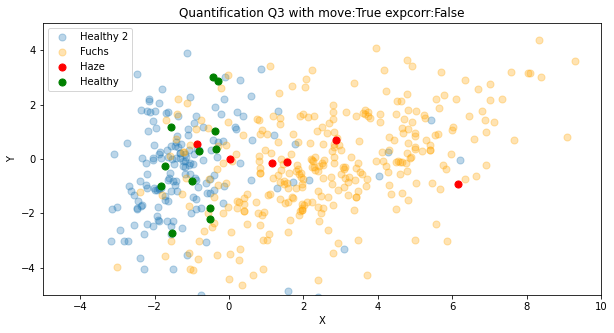

In [ ]:
plt.figure(figsize=(10,5))
alpha=0.3
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(data_fuchs_rep_new["Id_patient_eye"]))))
plt.scatter(data_healthy2_new["X"],data_healthy2_new["Y"],marker='o',s=50,label="Healthy 2",alpha=alpha)
plt.scatter(data_fuchs_new["X"],data_fuchs_new["Y"],marker='o',c="orange",s=50,label="Fuchs",alpha=alpha)
plt.scatter(data_haze_new["X"],data_haze_new["Y"],marker='o',c='r',s=50,label="Haze",alpha=1)
plt.scatter(data_healthy_new["X"],data_healthy_new["Y"],marker='o',c='g',s=50,label="Healthy",alpha=1)
plt.xlim([-5,10])
plt.ylim([-5,5])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Quantification Q3 with move:"+str(move)+" expcorr:"+str(useExpCorr))
plt.legend()

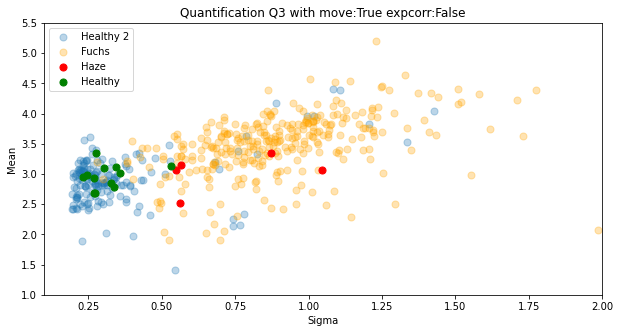

In [ ]:
plt.figure(figsize=(10,5))
alpha=0.3
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(data_fuchs_rep_new["Id_patient_eye"]))))
plt.scatter(data_healthy_2["Sigma"],data_healthy_2["Mean"],marker='o',s=50,label="Healthy 2",alpha=alpha)
plt.scatter(data_fuchs["Sigma"],data_fuchs["Mean"],marker='o',c="orange",s=50,label="Fuchs",alpha=alpha)
plt.scatter(data_haze["Sigma"],data_haze["Mean"],marker='o',c='r',s=50,label="Haze",alpha=1)
plt.scatter(data_healthy["Sigma"],data_healthy["Mean"],marker='o',c='g',s=50,label="Healthy",alpha=1)
plt.xlim([0.1,2])
plt.ylim([1,5.5])
plt.xlabel("Sigma")
plt.ylabel("Mean")
plt.title("Quantification Q3 with move:"+str(move)+" expcorr:"+str(useExpCorr))
plt.legend()

# Can we still classificate correctly ? 

In [ ]:
from sklearn.model_selection import LeaveOneOut
data_copy=(data_learning-np.mean(data_learning,0))/np.std(data_learning,0)
X=data_copy.drop(["Origin","Healthy"],axis=1)
X=X.to_numpy()
y=data_learning["Healthy"]
y=y.to_numpy()
# regr = svm.SVR()
# regr.fit(X, y)

loo = LeaveOneOut()
loo.get_n_splits(X)
result=[]
result_pred=[]
conf=np.zeros((2,2))
for train_index, test_index in loo.split(X):
	print("TRAIN:", train_index, "TEST:", test_index)
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	clf = svm.SVC()
	clf.fit(X_train, y_train)
	y_predict=clf.predict(X_test)
	result.append(y_test.ravel()[0])
	result_pred.append(y_predict.ravel()[0])
	if y_predict[0]==y_test[0] and y_test[0]==0:
		conf[0,0]+=1
	elif y_predict[0]!=y_test[0] and y_test[0]==1:
		print(y_predict,y_test)
		conf[0,1]+=1
	elif y_predict[0]!=y_test[0] and y_test[0]==0:
		conf[1,0]+=1
	elif y_predict[0]==y_test[0] and y_test[0]==1:
		conf[1,1]+=1
print(conf)


TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17] TEST: [13]
TRAIN: [ 0  1  2

In [ ]:
from sklearn.ensemble import RandomForestRegressor
data_copy=(data_learning-np.mean(data_learning,0))/np.std(data_learning,0)
X=data_copy.drop(["Origin","Healthy"],axis=1)

X=X.to_numpy()
y=data_learning["Healthy"]
y=y.to_numpy()

loo = LeaveOneOut()
loo.get_n_splits(X)
result=[]
result_pred=[]
conf=np.zeros((2,2))
for train_index, test_index in loo.split(X):
	print("TRAIN:", train_index, "TEST:", test_index)
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]
	rf = RandomForestRegressor(n_estimators = 100, random_state = 2020)
	rf.fit(X_train, y_train)
	y_predict=clf.predict(X_test)
	result.append(y_test.ravel()[0])
	result_pred.append(y_predict.ravel()[0])
	if y_predict[0]==y_test[0] and y_test[0]==0:
		conf[0,0]+=1
	elif y_predict[0]!=y_test[0] and y_test[0]==1:
		print(y_predict,y_test)
		conf[0,1]+=1
	elif y_predict[0]!=y_test[0] and y_test[0]==0:
		conf[1,0]+=1
	elif y_predict[0]==y_test[0] and y_test[0]==1:
		conf[1,1]+=1
print(conf)

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [0]
TRAIN: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [1]
TRAIN: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [2]
TRAIN: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [3]
TRAIN: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [4]
TRAIN: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17] TEST: [5]
TRAIN: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17] TEST: [6]
TRAIN: [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17] TEST: [7]
TRAIN: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17] TEST: [8]
TRAIN: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17] TEST: [9]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17] TEST: [10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17] TEST: [11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17] TEST: [12]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17] TEST: [13]
TRAIN: [ 0  1  2

# Plots

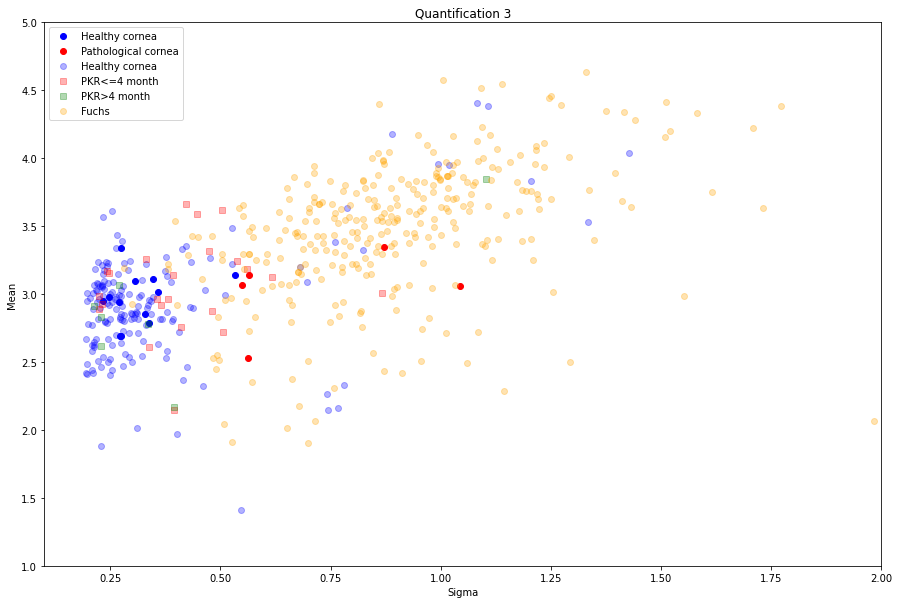

In [ ]:
plt.figure(figsize=(15,10))


plt.plot(data_healthy['Sigma'],data_healthy['Mean'],'o',color="blue",alpha=1,label="Healthy cornea")
plt.plot(data_haze['Sigma'],data_haze['Mean'],'o',color="red",alpha=1,label="Pathological cornea")

plt.plot(data_healthy_2['Sigma'],data_healthy_2['Mean'],'o',color="blue",alpha=0.3,label="Healthy cornea")

tho=4
bool_month=data_haze_2['Month']<=tho
plt.plot(data_haze_2['Sigma'][bool_month],data_haze_2['Mean'][bool_month],'s',color="red",alpha=0.3,label="PKR<={:.0f} month".format(tho))
bool_month=data_haze_2['Month']>tho
plt.plot(data_haze_2['Sigma'][bool_month],data_haze_2['Mean'][bool_month],'s',color="green",alpha=0.3,label="PKR>{:.0f} month".format(tho))

plt.plot(data_fuchs['Sigma'],data_fuchs['Mean'],'o',color="orange",alpha=0.3,label="Fuchs")

plt.ylim([1,5])
plt.xlim([0.1,2])
plt.xlabel("Sigma")
plt.ylabel("Mean")
plt.title("Quantification 3")
plt.legend()
plt.show()


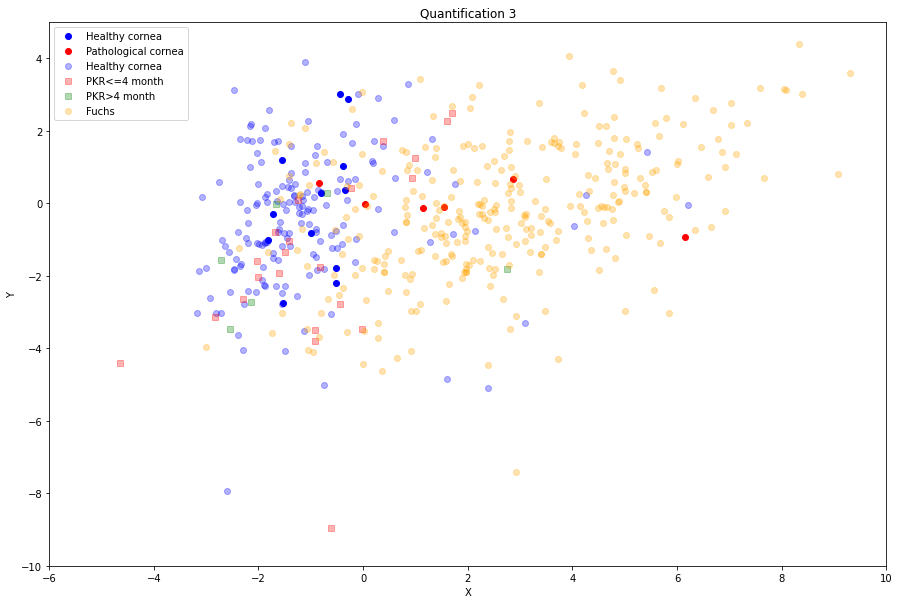

In [ ]:
plt.figure(figsize=(15,10))


plt.plot(data_healthy_new['X'],data_healthy_new['Y'],'o',color="blue",alpha=1,label="Healthy cornea")
plt.plot(data_haze_new['X'],data_haze_new['Y'],'o',color="red",alpha=1,label="Pathological cornea")

plt.plot(data_healthy2_new['X'],data_healthy2_new['Y'],'o',color="blue",alpha=0.3,label="Healthy cornea")

tho=4
bool_month=data_haze_2['Month']<=tho
plt.plot(data_haze2_new['X'][bool_month],data_haze2_new['Y'][bool_month],'s',color="red",alpha=0.3,label="PKR<={:.0f} month".format(tho))
bool_month=data_haze_2['Month']>tho
plt.plot(data_haze2_new['X'][bool_month],data_haze2_new['Y'][bool_month],'s',color="green",alpha=0.3,label="PKR>{:.0f} month".format(tho))

plt.plot(data_fuchs_new['X'],data_fuchs_new['Y'],'o',color="orange",alpha=0.3,label="Fuchs")

plt.ylim([-10,5])
plt.xlim([-6,10])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Quantification 3")
plt.legend()
plt.show()